In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'  
from pprint import pprint

In [3]:
import numpy as np
X_train=np.random.uniform(-1,1,(200,2))
Y_train=np.logical_xor(X_train[:,0]>0,X_train[:,1]>0).astype(int)
X_test=np.random.uniform(-1,1,(200,2))
Y_test=np.logical_xor(X_test[:,0]>0,X_test[:,1]>0).astype(int)


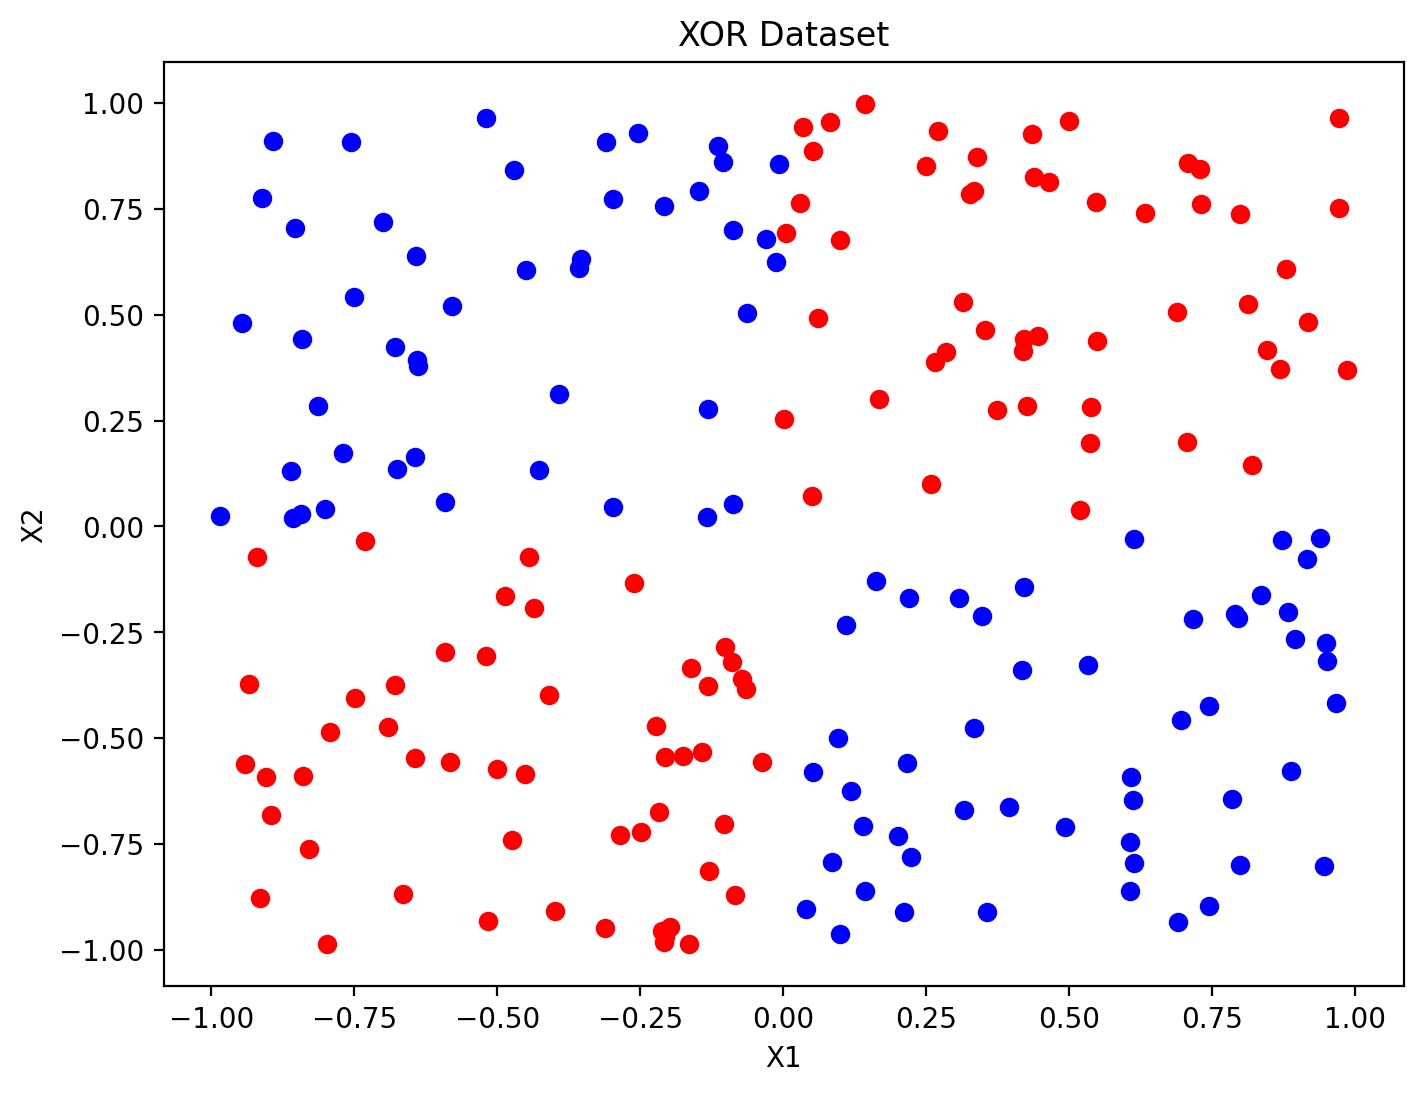

In [4]:
plt.figure(figsize=(8, 6))
for i in range(len(Y_train)):
    if Y_train[i] == 1:
        plt.scatter(X_train[i, 0], X_train[i, 1], c='blue')
    else:
        plt.scatter(X_train[i, 0], X_train[i, 1], c='red')

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("XOR Dataset")
plt.show()

In [5]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1) 

X_test_t = torch.tensor(X_test, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)


In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.hidden=nn.Linear(2,10)
        self.output=nn.Linear(10,1)
    def forward(self,x):
        x=torch.relu(self.hidden(x))
        x=torch.sigmoid(self.output(x))
        return x
model=MLP()

In [7]:
criterion = nn.BCELoss() 
opt = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
output=model(X_train_t)
output.shape


torch.Size([200, 1])

In [9]:
Y_train_t.shape

torch.Size([200, 1])

In [10]:
epochs=500
for i in range(1,epochs+1):
    model.train()
    output=model(X_train_t)
    loss=criterion(output,Y_train_t)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i%10==0:
        print("Epochs",i,"Loss: ", loss)

Epochs 10 Loss:  tensor(0.6702, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 20 Loss:  tensor(0.6318, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 30 Loss:  tensor(0.5811, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 40 Loss:  tensor(0.5285, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 50 Loss:  tensor(0.4771, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 60 Loss:  tensor(0.4321, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 70 Loss:  tensor(0.3960, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 80 Loss:  tensor(0.3692, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 90 Loss:  tensor(0.3506, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 100 Loss:  tensor(0.3383, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 110 Loss:  tensor(0.3303, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 120 Loss:  tensor(0.3251, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 130 Loss:  tensor(0.3218, grad_fn=<BinaryCrossEntropyBackward0>)
Epochs 140 Loss:  tensor(0.3197, grad_fn=<BinaryCrossEntropyBackward0>)
E

Test Accuracy: 85.00%


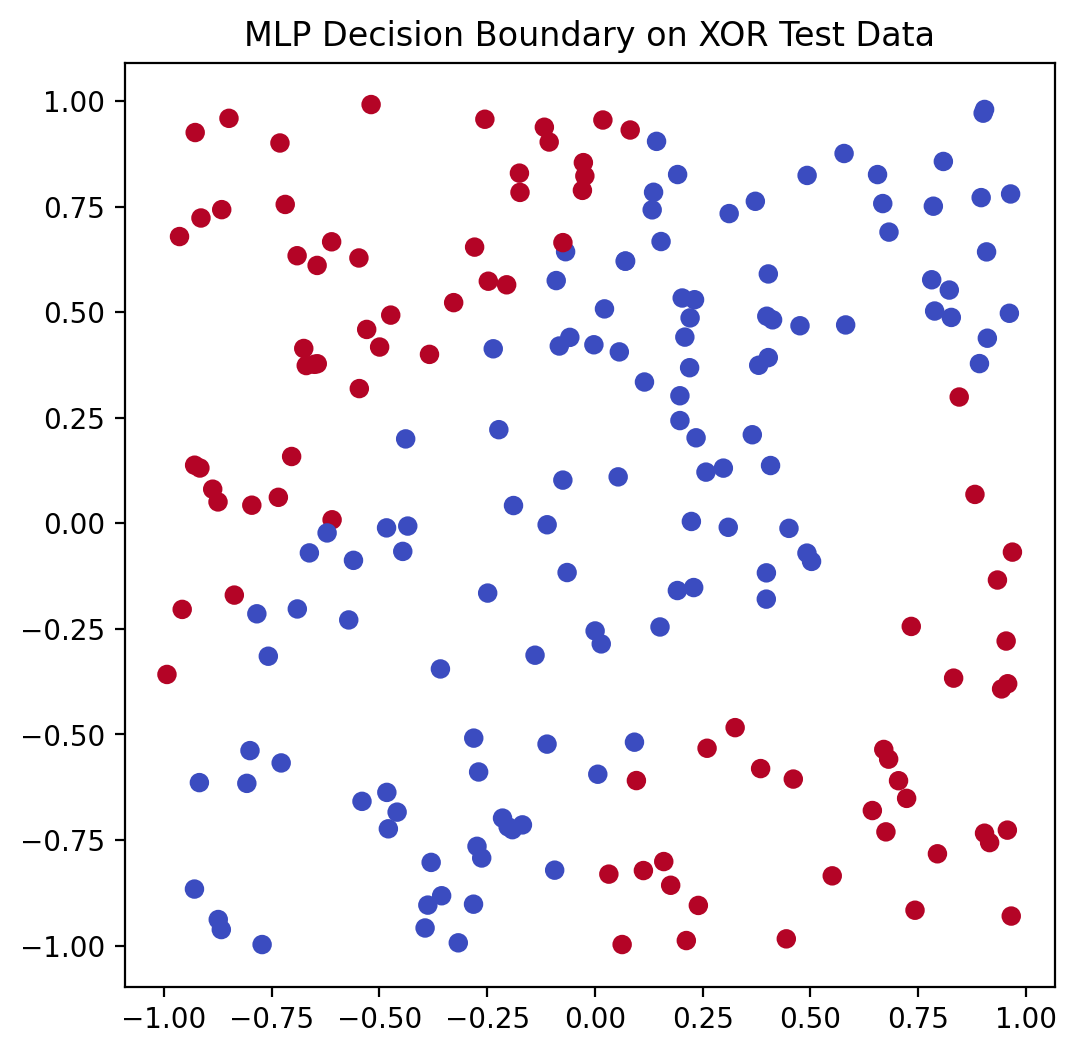

In [11]:
model.eval()
with torch.no_grad():
    output=model(X_test_t)
    pred=output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(6, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred.squeeze(), cmap='coolwarm')
plt.title('MLP Decision Boundary on XOR Test Data')
plt.show()


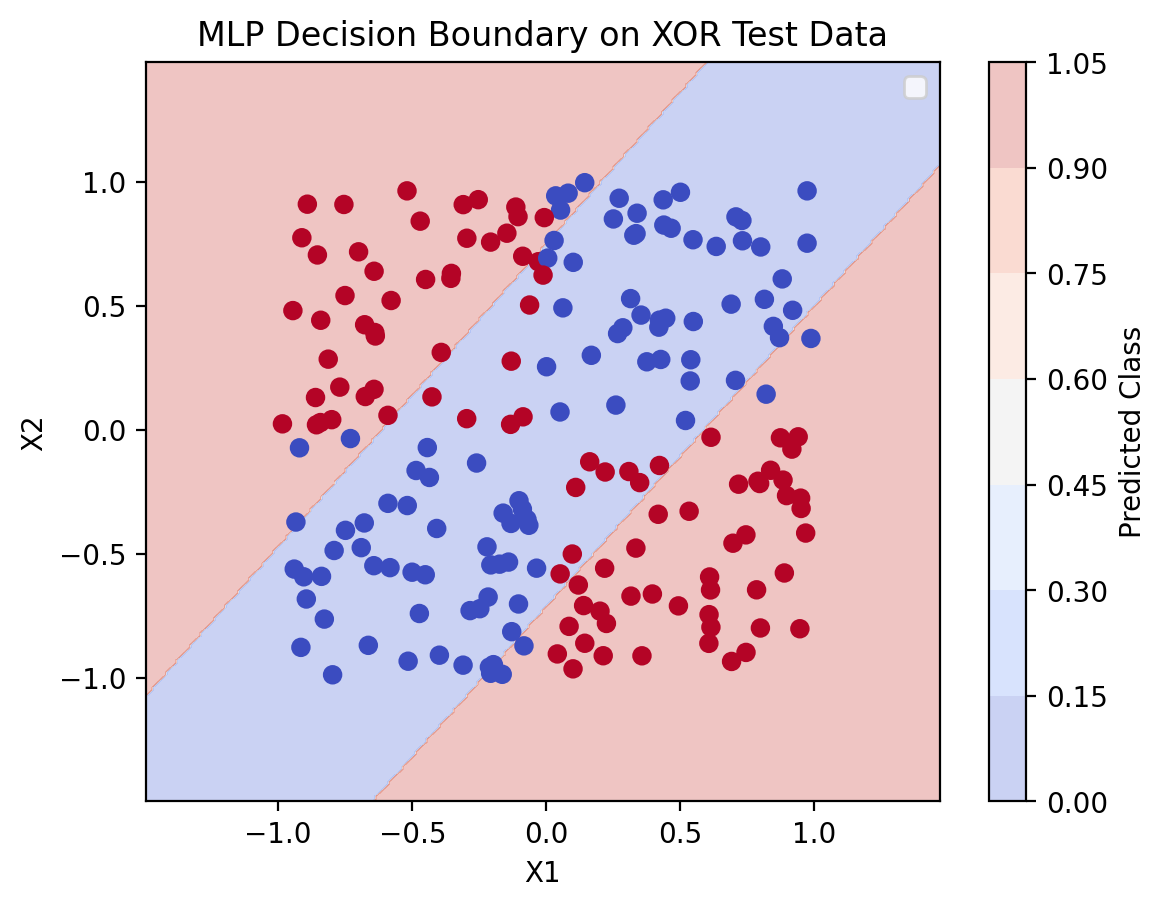

In [12]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class labels for all points in the meshgrid
grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("MLP Decision Boundary on XOR Test Data")
plt.legend()
plt.show()

# **MLP w/ L1 regularization**

In [13]:
def l1_reg(model, lamda):
    l1_norm=sum(p.abs().sum() for p in model.parameters())
    return lamda*l1_norm

X_val_t = X_train_t[160:]
Y_val_t = Y_train_t[160:]
X_train_t = X_train_t[:160]
Y_train_t = Y_train_t[:160]


In [14]:
lambda_l1=0.001
model = MLP()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 500
for epoch in range(1, epochs + 1):
    model.train()
    output = model(X_train_t)
    loss = criterion(output, Y_train_t) + l1_reg(model, lambda_l1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.7020
Epoch 20, Loss: 0.6894
Epoch 30, Loss: 0.6747
Epoch 40, Loss: 0.6539
Epoch 50, Loss: 0.6266
Epoch 60, Loss: 0.5936
Epoch 70, Loss: 0.5551
Epoch 80, Loss: 0.5124
Epoch 90, Loss: 0.4675
Epoch 100, Loss: 0.4231
Epoch 110, Loss: 0.3853
Epoch 120, Loss: 0.3567
Epoch 130, Loss: 0.3337
Epoch 140, Loss: 0.3147
Epoch 150, Loss: 0.2987
Epoch 160, Loss: 0.2843
Epoch 170, Loss: 0.2697
Epoch 180, Loss: 0.2569
Epoch 190, Loss: 0.2456
Epoch 200, Loss: 0.2350
Epoch 210, Loss: 0.2257
Epoch 220, Loss: 0.2162
Epoch 230, Loss: 0.2043
Epoch 240, Loss: 0.1883
Epoch 250, Loss: 0.1771
Epoch 260, Loss: 0.1694
Epoch 270, Loss: 0.1626
Epoch 280, Loss: 0.1558
Epoch 290, Loss: 0.1503
Epoch 300, Loss: 0.1459
Epoch 310, Loss: 0.1423
Epoch 320, Loss: 0.1393
Epoch 330, Loss: 0.1367
Epoch 340, Loss: 0.1343
Epoch 350, Loss: 0.1322
Epoch 360, Loss: 0.1302
Epoch 370, Loss: 0.1284
Epoch 380, Loss: 0.1267
Epoch 390, Loss: 0.1252
Epoch 400, Loss: 0.1237
Epoch 410, Loss: 0.1223
Epoch 420, Loss: 0.1210
E

In [15]:
model.eval()
with torch.no_grad():
    output = model(X_test_t)
    pred = output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 96.50%


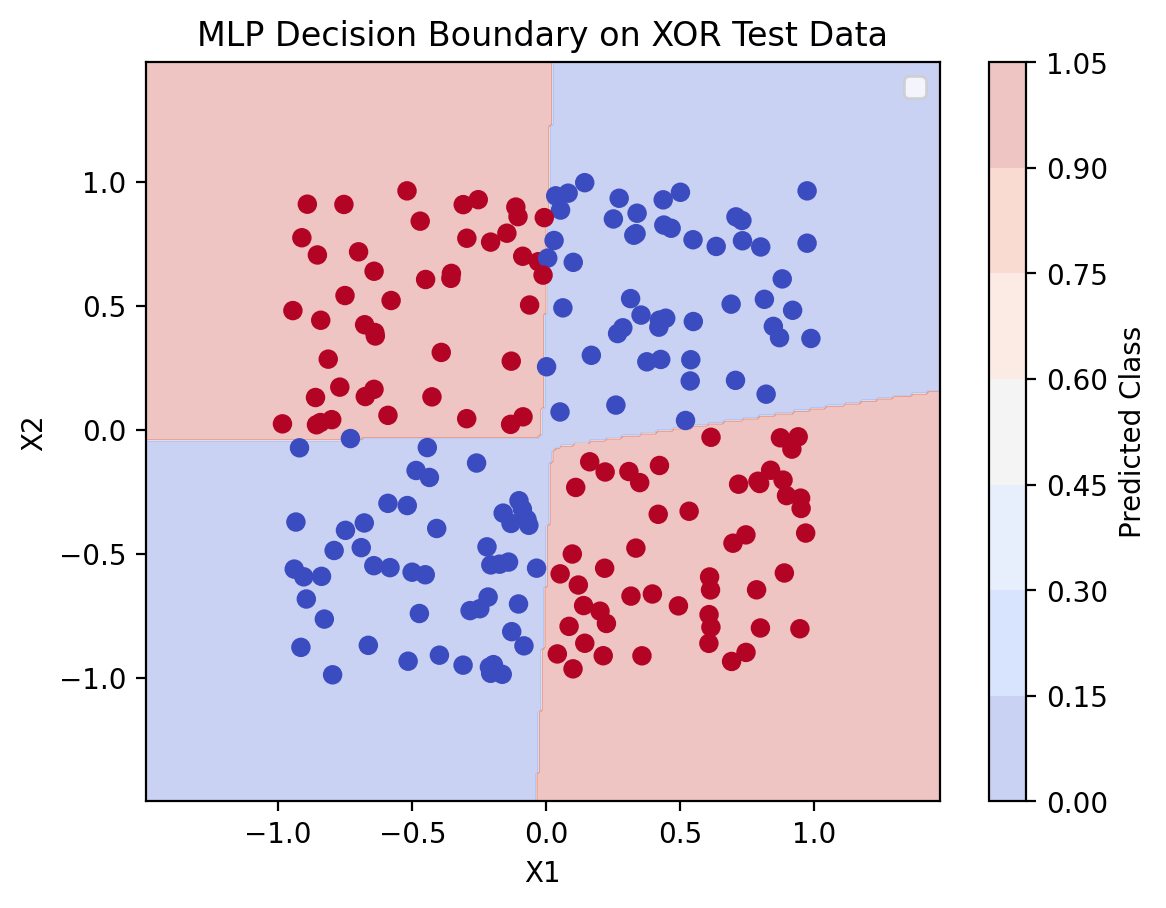

In [16]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class labels for all points in the meshgrid
grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("MLP Decision Boundary on XOR Test Data")
plt.legend()
plt.show()

In [17]:
l1_values = [ 0.01, 0.1]
model = MLP()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for lambda_l1 in l1_values:
    # Initialize and train the model as before
    model = MLP()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(1, epochs + 1):
        model.train()
        output = model(X_train_t)
        loss = criterion(output, Y_train_t) + l1_reg(model, lambda_l1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate model after training
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_t)
        val_pred = val_output.round()
        val_accuracy = (val_pred.eq(Y_val_t).sum() / float(Y_val_t.shape[0])).item()
        print(f'L1 Lambda: {lambda_l1}, Validation Accuracy: {val_accuracy * 100:.2f}%')

L1 Lambda: 0.01, Validation Accuracy: 75.00%
L1 Lambda: 0.1, Validation Accuracy: 62.50%


# **MLP w/ L2**

In [18]:
lambda_l2 = 0.001  # L2 regularization parameter
model = MLP()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_l2)

In [19]:
epochs = 500
for epoch in range(1, epochs + 1):
    model.train()
    output = model(X_train_t)
    loss = criterion(output, Y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.7127
Epoch 20, Loss: 0.6823
Epoch 30, Loss: 0.6624
Epoch 40, Loss: 0.6444
Epoch 50, Loss: 0.6217
Epoch 60, Loss: 0.5917
Epoch 70, Loss: 0.5556
Epoch 80, Loss: 0.5142
Epoch 90, Loss: 0.4685
Epoch 100, Loss: 0.4208
Epoch 110, Loss: 0.3743
Epoch 120, Loss: 0.3316
Epoch 130, Loss: 0.2917
Epoch 140, Loss: 0.2550
Epoch 150, Loss: 0.2226
Epoch 160, Loss: 0.1945
Epoch 170, Loss: 0.1706
Epoch 180, Loss: 0.1506
Epoch 190, Loss: 0.1346
Epoch 200, Loss: 0.1219
Epoch 210, Loss: 0.1118
Epoch 220, Loss: 0.1038
Epoch 230, Loss: 0.0973
Epoch 240, Loss: 0.0920
Epoch 250, Loss: 0.0877
Epoch 260, Loss: 0.0841
Epoch 270, Loss: 0.0811
Epoch 280, Loss: 0.0785
Epoch 290, Loss: 0.0764
Epoch 300, Loss: 0.0745
Epoch 310, Loss: 0.0729
Epoch 320, Loss: 0.0716
Epoch 330, Loss: 0.0704
Epoch 340, Loss: 0.0694
Epoch 350, Loss: 0.0685
Epoch 360, Loss: 0.0677
Epoch 370, Loss: 0.0670
Epoch 380, Loss: 0.0664
Epoch 390, Loss: 0.0659
Epoch 400, Loss: 0.0654
Epoch 410, Loss: 0.0650
Epoch 420, Loss: 0.0646
E

In [20]:
model.eval()
with torch.no_grad():
    output = model(X_test_t)
    pred = output.round()
    accuracy = (pred.eq(Y_test_t).sum() / float(Y_test_t.shape[0])).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 96.00%


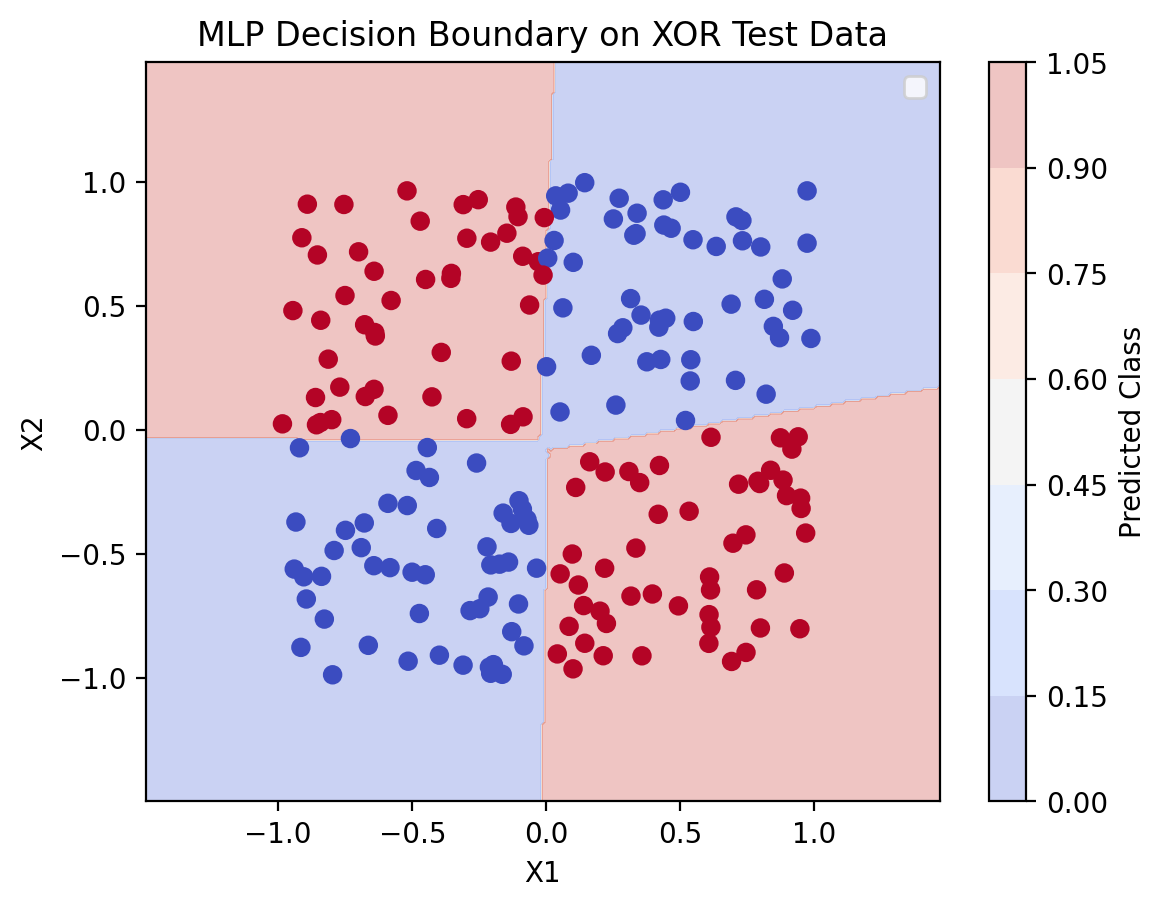

In [21]:
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class labels for all points in the meshgrid
grid_data = np.c_[xx.ravel(), yy.ravel()]
grid_data_t = torch.tensor(grid_data, dtype=torch.float32)
with torch.no_grad():
    Z = model(grid_data_t)
    Z = Z.round().numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.colorbar(label='Predicted Class')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("MLP Decision Boundary on XOR Test Data")
plt.legend()
plt.show()

In [22]:
l2_values = [0.001, 0.01, 0.1]
for lambda_l2 in l2_values:
    # Initialize and train the model as before
    model = MLP()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_l2)
    for epoch in range(1, epochs + 1):
        model.train()
        output = model(X_train_t)
        loss = criterion(output, Y_train_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate model after training
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_t)
        val_pred = val_output.round()
        val_accuracy = (val_pred.eq(Y_val_t).sum() / float(Y_val_t.shape[0])).item()
        print(f'L2 Lambda: {lambda_l2}, Validation Accuracy: {val_accuracy * 100:.2f}%')

L2 Lambda: 0.001, Validation Accuracy: 100.00%
L2 Lambda: 0.01, Validation Accuracy: 100.00%
L2 Lambda: 0.1, Validation Accuracy: 37.50%


# additional Feature

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [24]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
log_reg = LogisticRegression()
log_reg.fit(X_train_poly, Y_train)


LogisticRegression()

In [25]:
y_pred = log_reg.predict(X_test_poly)
accuracy = accuracy_score(Y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 93.00%


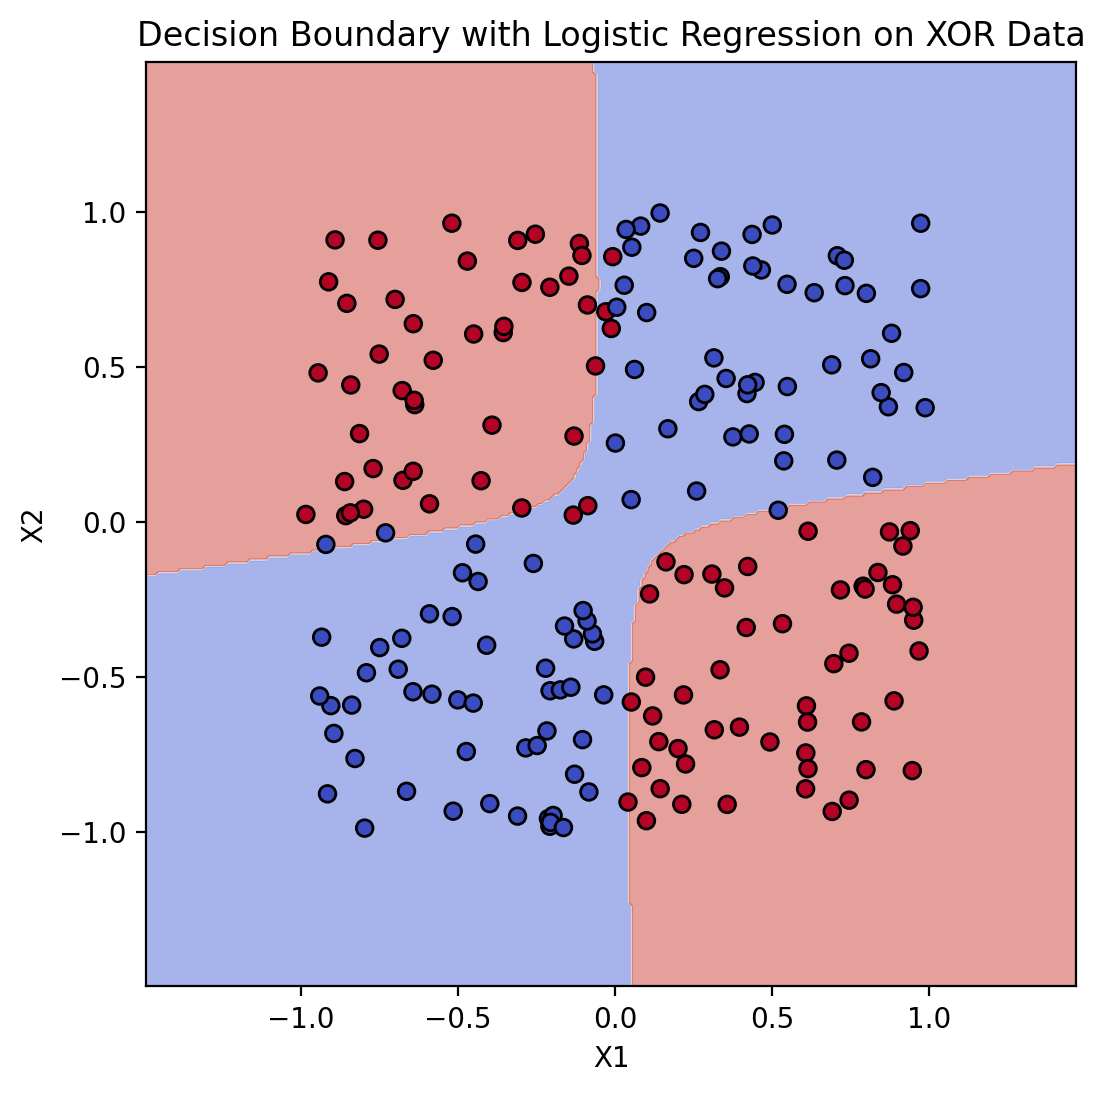

In [26]:
# Create a grid of points for the decision surface
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Transform the grid points
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_poly = poly.transform(grid_points)

# Predict for the grid points
Z = log_reg.predict(grid_points_poly).reshape(xx.shape)

# Plot decision surface
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm')
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='coolwarm', edgecolors='k')
plt.title('Decision Boundary with Logistic Regression on XOR Data')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()